<a href="https://colab.research.google.com/github/JR-1991/sysbiojax/blob/master/TestOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Plan

* ✅ Convert datasets into arrays of shape 
  * [Replicate, Time, Species]
* ✅ VMap the simulate function to iterate over each SaveAt and Y0 in parallel
  * Keep Parameters constant!
  * Each measurement has a y0 and timesteps plus data
  * In case of replicates, duplicate y0
* Upon conversion to a tensor, zero-pad data to the maximum array size
  * This addresses varying sample times
  * For beginning, lets stick with constant SaveAt array sizes for now
* Effectively, simulate and calculate residuals simultaneously
  * Jit this for maximum performance!
* Run LMFit as usual, as most of the overhead comes from function evaluation

In [1]:
from sysbiojax import Model

/Users/max/miniconda3/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
%load_ext autoreload
%autoreload 2
from sysbiojax.tools.parameterestimation import ParameterEstimator

In [2]:
import jax
import jax.numpy as jnp
from jax import config
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters

from typing import List, Dict

config.update("jax_enable_x64", True)

In [3]:
# Initialize the model
model = Model(name="Simple menten model")

# Add species
model.add_species("s1, p0")

# Add ODEs
model.add_ode("s1", "- (kcat * p0 * s1) / ( K_m + s1)")
model.add_ode("p0", "- k * p0")

# Add parameter values
model.parameters.kcat.value = 20
model.parameters.kcat.lower_bound = 1
model.parameters.k.value = 0
model.parameters.K_m.value = 200
model.parameters.K_m.lower_bound = 1

model

Model summary


Eq(x, Matrix([[s1, p0]]))

Eq(theta, Matrix([[K_m, kcat, k]]))

Eq(Derivative(s1, t), -kcat*p0*s1/(K_m + s1))

Eq(Derivative(p0, t), -k*p0)

,name,symbol,value,initial_value,equation,lower_bound,upper_bound,stdev
0,K_m,K_m,200,None,None,1.0,None,None
1,kcat,kcat,20,None,None,1.0,None,None
2,k,k,0,None,None,NaN,None,None


(4, 100)

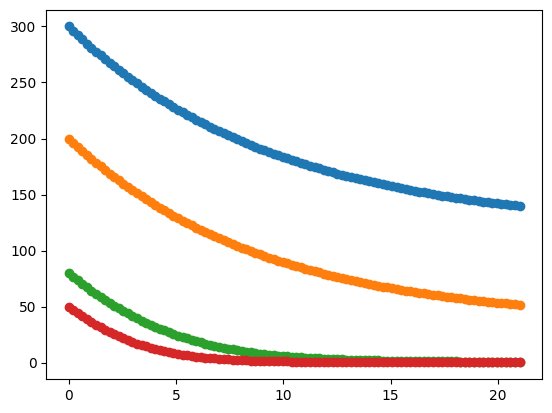

In [4]:
# Generate irregular time series data generated
# from a simple menten model

# Data is sampled at different time points
# and also not at zero to reflect realistic
# scenarios
time = jnp.tile(jnp.linspace(0, 21, 100), 4).reshape(4, 100)

# Set initial conditions above and below the
# true Km value for the sake of the example
initial_conditions = [
    {"s1": 300.0, "p0": 1},
    {"s1": 200.0, "p0": 1},
    {"s1": 80.0, "p0": 1},
    {"s1": 50.0, "p0": 1},
]

# K_m, k, kcat
params = jnp.array([20, 0.1, 20])

time, data = model.simulate(
    initial_conditions=initial_conditions,
    dt0=0.1,
    saveat=time,
    parameters=params,
    in_axes=(0, None, 0),
)

substrate_measurements = data[:, :, 1]


for t, d in zip(time, substrate_measurements):
    plt.scatter(t, d)

substrate_measurements.shape

In [29]:
model.parameters

,name,symbol,value,initial_value,equation,lower_bound,upper_bound,stdev
0,K_m,K_m,200,None,None,1.0,None,None
1,kcat,kcat,20,None,None,1.0,None,None
2,k,k,0,None,None,NaN,None,None


In [32]:
estimator = ParameterEstimator(
    model=model,
    data=data,
    time=time,
    initial_states=initial_conditions,
)

result = estimator.fit()
result